# Text Classification - OneClass Classificaiton

The one-class algorithms are based on recognition since their aim is to recognize data from a particular class, and reject data from all other classes. This is accomplished by creating a boundary that encompasses all the data belonging to the target class within itself, so when a new sample arrives the algorithm only has to check whether it lies within the boundary or outside and accordingly classify the sample as belonging to the target class or the outlier.

Things we are going to discuss:

1. Data Preparation 
2. Cleaning and Tokenization
3. Feature Extraction
4. Train One-class classificaiton model
5. Predict one-class on test data

In [1]:
# Load packages
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.utils import shuffle
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import string
import spacy
from spacy.lang.en import English
spacy.load('en')
parser = English()

In [2]:
# load dataset
bbc_df = pd.read_csv('./bbc-text.csv')

In [3]:
bbc_df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [4]:
bbc_df.shape

(2225, 2)

In [5]:
bbc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
category    2225 non-null object
text        2225 non-null object
dtypes: object(2)
memory usage: 34.8+ KB


In [6]:
# change datatype to string
bbc_df = bbc_df[["category","text"]].astype(str)

In [7]:
# check labels in category
bbc_df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [8]:
# check counts of each category
bbc_df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

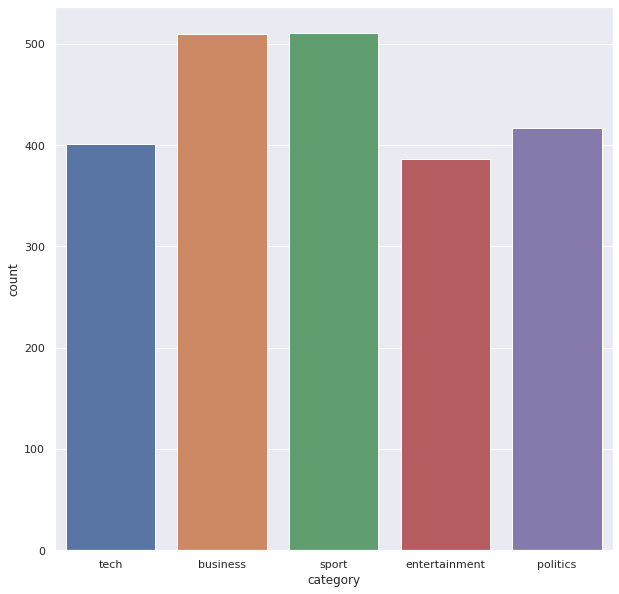

In [9]:
sns.set(rc={'figure.figsize':(10,10)})
sns.countplot(bbc_df['category'])

## Data preparation

Let's take "sport" category as our traning class for one-class classification

so let's replace the category labels

Since "sport" is our traning class let's replace "sport" with "1" and replace "business, politics, tech and entertainment" with "-1"

becuase one-class classification model prediction will be 1 or -1

here "1" is target class and "-1" is the outlier

In [10]:
# change category labels
bbc_df['category'] = bbc_df['category'].map({'sport':1,'business':-1,'politics':-1,'tech':-1,'entertainment':-1})

In [11]:
# create a new dataset with only sport category data
sports_df = bbc_df[bbc_df['category'] == 1]

In [12]:
sports_df.shape

(511, 2)

In [13]:
# create train and test data
train_text = sports_df['text'].tolist()
train_labels = sports_df['category'].tolist()

test_text = bbc_df['text'].tolist()
test_labels = bbc_df['category'].tolist()

## Data Cleaning and Tokenization

In [14]:
# stop words list
STOPLIST = set(stopwords.words('english') + list(ENGLISH_STOP_WORDS)) 
# special characters
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "...", "”", "”","''"]

In [15]:
# class for cleaning the text
class CleanTextTransformer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
            return {}

def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

In [16]:
# tokenizing the raw text
def tokenizeText(sample):
    
    tokens = parser(sample)
    
    # lemmatization
    lemmas = []
    for tok in tokens:
        lemmas.append(tok.lemma_.lower().strip() if tok.lemma_ != "-PRON-" else tok.lower_)
    tokens = lemmas
    
    # remove stop words and special characters
    tokens = [tok for tok in tokens if tok.lower() not in STOPLIST]
    tokens = [tok for tok in tokens if tok not in SYMBOLS]
    
    # only take words with length greater than or equal to 3
    tokens = [tok for tok in tokens if len(tok) >= 3]
    
    # remove remaining tokens that are not alphabetic
    tokens = [tok for tok in tokens if tok.isalpha()]
    
    # stemming of words
    porter = PorterStemmer()
    tokens = [porter.stem(word) for word in tokens]
    
    return list(set(tokens))

In [17]:
# lets see tokenized random text
tokenizeText(train_text[9])

['look',
 'turn',
 'trophi',
 'littl',
 'set',
 'tiebreak',
 'class',
 'defeat',
 'dubai',
 'triumph',
 'star',
 'rhythm',
 'victori',
 'cours',
 'confid',
 'claim',
 'absolut',
 'numb',
 'henman',
 'great',
 'bite',
 'perform',
 'suddenli',
 'ivan',
 'rotterdam',
 'time',
 'success',
 'belong',
 'test',
 'loos',
 'player',
 'final',
 'away',
 'world',
 'indoor',
 'loss',
 'championship',
 'chanc',
 'style',
 'start',
 'twice',
 'week',
 'poor',
 'easi',
 'beat',
 'year',
 'tournament',
 'dig',
 'cool',
 'serv',
 'want',
 'stretch',
 'run',
 'posit',
 'know',
 'come',
 'explain',
 'fli',
 'game',
 'list',
 'crown',
 'quick',
 'boost',
 'troubl',
 'tim',
 'court',
 'weird',
 'badli',
 'tens',
 'overal',
 'roger',
 'ljubic',
 'deep',
 'thump',
 'ball',
 'racket',
 'feder',
 'good',
 'lose',
 'decid',
 'say',
 'effort',
 'like',
 'way',
 'feel',
 'long',
 'match',
 'secur',
 'despit',
 'add',
 'play',
 'win',
 'seed',
 'realli',
 'swiss',
 'relax']

## Feature Extraction

In [18]:
# getting features
vectorizer = HashingVectorizer(n_features=20,tokenizer=tokenizeText)

features = vectorizer.fit_transform(train_text).toarray()
features.shape

(511, 20)

## One-class SVM

One-class SVM is an unsupervised algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set.

In [19]:
# OneClassSVM algorithm
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
pipe_clf = Pipeline([('cleanText', CleanTextTransformer()), ('vectorizer', vectorizer), ('clf', clf)])

In [20]:
# fit OneClassSVM model 
pipe_clf.fit(train_text, train_labels)

Pipeline(memory=None,
         steps=[('cleanText',
                 <__main__.CleanTextTransformer object at 0x7fb7df1b7160>),
                ('vectorizer',
                 HashingVectorizer(alternate_sign=True, analyzer='word',
                                   binary=False, decode_error='strict',
                                   dtype=<class 'numpy.float64'>,
                                   encoding='utf-8', input='content',
                                   lowercase=True, n_features=20,
                                   ngram_range=(1, 1), norm='l2',
                                   preprocessor=None, stop_words=None,
                                   strip_accents=None,
                                   token_pattern='(?u)\\b\\w\\w+\\b',
                                   tokenizer=<function tokenizeText at 0x7fb7df1de1e0>)),
                ('clf',
                 OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=0.1,
                             kernel='rbf'

In [21]:
# validate OneClassSVM model with train set
preds_train = pipe_clf.predict(train_text)

print("accuracy:", accuracy_score(train_labels, preds_train))

accuracy: 0.8199608610567515


In [22]:
# validate OneClassSVM model with test set
preds_test = pipe_clf.predict(test_text)
preds_test

array([ 1, -1,  1, ..., -1,  1,  1])

In [23]:
results = confusion_matrix(test_labels, preds_test) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(test_labels, preds_test)) 
print('Report : ')
print(classification_report(test_labels, preds_test)) 

Confusion Matrix :
[[966 748]
 [ 92 419]]
Accuracy Score : 0.6224719101123596
Report : 
              precision    recall  f1-score   support

          -1       0.91      0.56      0.70      1714
           1       0.36      0.82      0.50       511

    accuracy                           0.62      2225
   macro avg       0.64      0.69      0.60      2225
weighted avg       0.79      0.62      0.65      2225



Let's check how model is performing 

In [24]:
# let's take random text from dataset
test_text[3]

'yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round.  the game - arguably the highlight of the draw - is a potential money-spinner for non-league yeading  who beat slough in the second round. conference side exeter city  who knocked out doncaster on saturday  will travel to old trafford to meet holders manchester united in january. arsenal were drawn at home to stoke and chelsea will play host to scunthorpe. the only other non-league side in the draw are hinckley united  who held brentford to a goalless draw on sunday. they will meet league one leaders luton if they win their replay against martin allen s team at griffin park.  a number of premiership teams face difficult away games against championship sides on the weekend of 8/9 january. third-placed everton visit plymouth  liverpool travel to burnley  crystal palace go to sunderland  fulham face carling cup semi-finalists watford  bolton me

In [25]:
# check actual category
test_labels[3]

1

In [26]:
# let's predict the category of above random text
pipe_clf.predict([test_text[3]])

array([1])

our model predicted random text as sport category which is correct